In [36]:
# LIME for Explainable AI
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# File handling and image processing
import os
import cv2
import numpy as np

# Keras Libraries for Model Building
from keras.utils import to_categorical  # Updated import for consistency
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten  # Conv2D is the updated syntax for Convolution2D
from keras.callbacks import ModelCheckpoint

# Sklearn for Model Evaluation
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
)
from sklearn.model_selection import train_test_split

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")


Using TensorFlow backend.


In [37]:
# Initialize lists for data and labels
X = []
Y = []

# Path to your dataset folder
path = r"C:\Users\LASYA\Desktop\SAR_Classification_Project\sar images"

# Class labels
labels = []  


In [38]:
import os

# Path to your dataset
path = r"C:\Users\LASYA\OneDrive\Desktop\SAR_Classification_Project\sar images"

# List terrain types
terrain_types = [folder for folder in os.listdir(path) if os.path.isdir(os.path.join(path, folder))]

print("Detected Terrain Types in SAR Images: ", terrain_types)


Detected Terrain Types in SAR Images:  ['agri', 'barrenland', 'grassland', 'urban']


In [39]:
#function to get integer id for given sar image area
def getLabel(name):
    index = -1
    for i in range(len(labels)):
        if labels[i] == name:
            index = i
            break
    return index


 Expected Labels: ['agri', 'barrenland', 'grassland', 'urban']
 Found Folders  : ['agri', 'barrenland', 'grassland', 'urban']
⚠ WARNING: Skipping unknown folder 'sar images'

 Loading images from: agri (4000 files found)


Processing agri: 100%|████████████████████████████████████████████████████████████| 4000/4000 [00:23<00:00, 169.21it/s]



 Loading images from: barrenland (4000 files found)


Processing barrenland: 100%|██████████████████████████████████████████████████████| 4000/4000 [00:23<00:00, 167.43it/s]



 Loading images from: grassland (4000 files found)


Processing grassland: 100%|███████████████████████████████████████████████████████| 4000/4000 [00:23<00:00, 167.14it/s]



 Loading images from: urban (4000 files found)


Processing urban: 100%|███████████████████████████████████████████████████████████| 4000/4000 [00:25<00:00, 158.55it/s]



 SAR Image Loading Completed
 Total images found in dataset = 16000


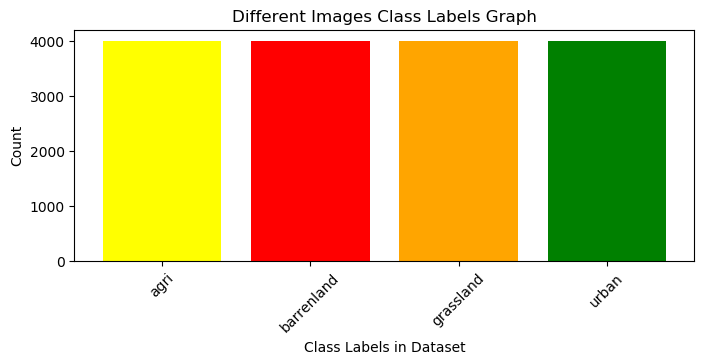

 Dataset saved successfully!


In [40]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Path to your SAR image dataset
path = r"C:\Users\LASYA\OneDrive\Desktop\SAR_Classification_Project\sar images"

# Define class labels (must match folder names exactly!)
labels = ['agri', 'barrenland', 'grassland', 'urban']

# Function to get class label index
def getLabel(name):
    if name in labels:
        return labels.index(name)
    return -1  # Return -1 if folder name is incorrect

#Step 1: Check if dataset path exists
if not os.path.exists(path):
    print(f"❗ ERROR: Dataset path '{path}' does not exist. Check your folder location.")
    exit()

#Step 2: Check actual subfolder names
actual_folders = next(os.walk(path))[1]  # Get subfolder names
print("\n Expected Labels:", labels)
print(" Found Folders  :", actual_folders)

#Step 3: Load images and labels
X = []
Y = []

for root, dirs, files in os.walk(path):
    folder_name = os.path.basename(root)  # Extract folder name
    label = getLabel(folder_name)  # Get corresponding label index
    
    if label == -1:
        print(f"⚠ WARNING: Skipping unknown folder '{folder_name}'")
        continue  # Skip folders not in 'labels'

    print(f"\n Loading images from: {folder_name} ({len(files)} files found)")
    
    for file in tqdm(files, desc=f"Processing {folder_name}"):
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp')) and 'Thumbs.db' not in file:
            img_path = os.path.join(root, file)
            img = cv2.imread(img_path)

            # Check if image is unreadable or corrupted
            if img is None:
                print(f" ERROR: Cannot read file '{img_path}' (corrupted or unsupported format)")
                continue
            
            img = cv2.resize(img, (32, 32))  # Resize for consistency
            X.append(img)
            Y.append(label)  # Store corresponding label

# Step 4: Convert lists to numpy arrays
if len(X) == 0:
    print(" ERROR: No images found in the dataset. Check the folder structure.")
    exit()

X = np.array(X)
Y = np.array(Y)

print("\n SAR Image Loading Completed")
print(f" Total images found in dataset = {X.shape[0]}")

# Step 5: Visualizing class label distribution
names, count = np.unique(Y, return_counts=True)
plt.figure(figsize=(8, 3))
plt.bar([labels[i] for i in names], count, color=['yellow', 'red', 'orange', 'green'])
plt.xlabel("Class Labels in Dataset")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.title("Different Images Class Labels Graph")
plt.show()

#Step 6: Save dataset for future use
np.save('model/X.npy', X)
np.save('model/Y.npy', Y)
print(" Dataset saved successfully!")


In [41]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Cell [3]: Dataset processing: shuffling and normalizing
X = X.astype('float32')
X /= 255  # Normalize images to [0, 1]

indices = np.arange(X.shape[0])
np.random.shuffle(indices)  # Shuffle images
X = X[indices]
Y = Y[indices]

# Convert labels to one-hot encoded format
Y = to_categorical(Y)

print("Images Shuffling & Normalization completed!")



Images Shuffling & Normalization completed!


In [42]:
import numpy as np
from sklearn.model_selection import train_test_split

# Use Y as is (no stratification)
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# Print dataset split details
print("Dataset Train & Test Split Details")
print(f"80% image files used to train algorithms: {X_train.shape[0]}")
print(f"20% image files used to test algorithms: {X_test.shape[0]}")


Dataset Train & Test Split Details
80% image files used to train algorithms: 12800
20% image files used to test algorithms: 3200


In [43]:
#define global variables to save accuracy and other metrics
accuracy = []
precision = []
recall = []
fscore = []

In [44]:
# Function to calculate all metrics
def calculateMetrics(algorithm, testY, predict):
    p = precision_score(testY, predict, average='macro') * 100
    r = recall_score(testY, predict, average='macro') * 100
    f = f1_score(testY, predict, average='macro') * 100
    a = accuracy_score(testY, predict) * 100
    
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    
    print(f"{algorithm} Accuracy  : {a:.2f}%")
    print(f"{algorithm} Precision : {p:.2f}%")
    print(f"{algorithm} Recall    : {r:.2f}%")
    print(f"{algorithm} FSCORE    : {f:.2f}%")
    
    # Confusion matrix
    conf_matrix = confusion_matrix(testY, predict)
    labels = ['Urban', 'Agricultural', 'Grassland', 'Barren']
    
    ax = sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, 
                     annot=True, cmap="viridis", fmt="g")
    ax.set_ylim(len(labels) - 0.5, -0.5)
    
    plt.title(f"{algorithm} Confusion Matrix")
    plt.show()
    plt.close()


X shape: (16000, 32, 32, 3)
Y shape: (16000, 4)
Y_flat shape: (16000,)
X_train shape: (12800, 32, 32, 3)
y_train shape: (12800, 4)
X_test shape: (3200, 32, 32, 3)
y_test shape: (3200, 4)
Train on 12800 samples, validate on 3200 samples
Epoch 1/20
12736/12800 [============================>.] - ETA: 0s - loss: 0.6353 - acc: 0.7321
Epoch 00001: val_loss improved from inf to 0.45476, saving model to model\cnn_weights.hdf5
12800/12800 [==============================] - 12s 912us/sample - loss: 0.6339 - acc: 0.7327 - val_loss: 0.4548 - val_acc: 0.8222
Epoch 2/20
12736/12800 [============================>.] - ETA: 0s - loss: 0.4142 - acc: 0.8401
Epoch 00002: val_loss improved from 0.45476 to 0.34253, saving model to model\cnn_weights.hdf5
12800/12800 [==============================] - 10s 801us/sample - loss: 0.4137 - acc: 0.8403 - val_loss: 0.3425 - val_acc: 0.8706
Epoch 3/20
12736/12800 [============================>.] - ETA: 0s - loss: 0.3135 - acc: 0.8835
Epoch 00003: val_loss did not imp

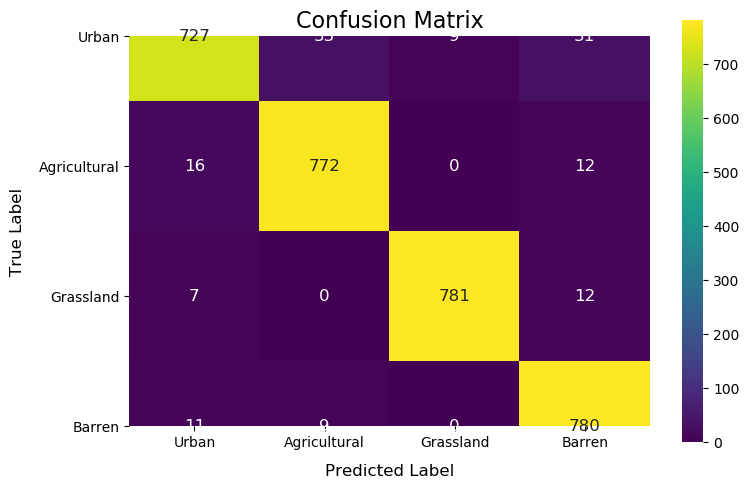

Dataset Train & Test Split Details
80% image files used to train algorithms: 12800
20% image files used to test algorithms: 3200


In [46]:
import os
import pickle
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Ensure model directory exists
os.makedirs("model", exist_ok=True)

# Verify input shapes
print("X shape:", X.shape)
print("Y shape:", Y.shape)

# Fix Y to have 16000 samples and convert to 1D class indices
# Y is (16000, 4), where 4 is the class dimension
Y_flat = np.argmax(Y, axis=1)  # Shape: (16000,)
print("Y_flat shape:", Y_flat.shape)

# Splitting dataset into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, Y_flat, test_size=0.2, random_state=42, stratify=Y_flat
)

# Convert y_train and y_test to one-hot encoded format for 4 classes
y_train = to_categorical(y_train, num_classes=4)  # Shape: (12800, 4)
y_test = to_categorical(y_test, num_classes=4)    # Shape: (3200, 4)

# Verify shapes after split
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Define model for 4 classes
cnn_model = Sequential()
cnn_model.add(Convolution2D(32, (3, 3), input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Convolution2D(32, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(units=256, activation='relu'))
cnn_model.add(Dense(units=4, activation='softmax'))  # 4 classes

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# File paths
weights_path = os.path.join("model", "cnn_weights.hdf5")
history_path = os.path.join("model", "cnn_history.pckl")

# Force retraining to ensure weights match 4-class model
checkpoint = ModelCheckpoint(filepath=weights_path, verbose=1, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

hist = cnn_model.fit(X_train, y_train, batch_size=64, epochs=20,
                     validation_data=(X_test, y_test),
                     callbacks=[checkpoint, early_stop], verbose=1)

with open(history_path, 'wb') as f:
    pickle.dump(hist.history, f)

# Predict and evaluate
predictions = cnn_model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)  # Shape: (3200,)
y_true = np.argmax(y_test, axis=1)       # Shape: (3200,)

# Verify prediction shapes
print("predictions shape:", predictions.shape)
print("y_pred shape:", y_pred.shape)
print("y_true shape:", y_true.shape)

# Convert y_true and y_pred to their corresponding labels
labels = ["Urban", "Agricultural", "Grassland", "Barren"]
y_true_labels = [labels[true] for true in y_true]
y_pred_labels = [labels[pred] for pred in y_pred]

# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="viridis",
    xticklabels=labels,
    yticklabels=labels,
    square=True,
    cbar_kws={'shrink': 0.75},
    annot_kws={"size": 12}
)

# Title & axis labels
ax.set_title("Confusion Matrix", fontsize=16)
ax.set_xlabel("Predicted Label", fontsize=12, labelpad=10)
ax.set_ylabel("True Label", fontsize=12, labelpad=10)

# Fixing tick label rotation & layout
plt.xticks(rotation=0, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

# Print dataset split details
print("Dataset Train & Test Split Details")
print(f"80% image files used to train algorithms: {X_train.shape[0]}")
print(f"20% image files used to test algorithms: {X_test.shape[0]}")

In [47]:
from tensorflow.keras.models import load_model

# Load the model from the correct path
model = load_model(r"C:\Users\LASYA\OneDrive\Desktop\SAR_Classification_Project\model\cnn_model.h5")
print("Model loaded successfully")


Model loaded successfully


In [48]:
from lime import lime_image
from skimage.segmentation import mark_boundaries  # Required for visualization

# Create LIME image explainer
explainer = lime_image.LimeImageExplainer()
print("LIME model loaded successfully")


LIME model loaded successfully


In [49]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import quickshift
from lime import lime_image
from tensorflow.keras.models import load_model

# Load trained model
model_path = r"C:\Users\LASYA\OneDrive\Desktop\SAR_Classification_Project\model\cnn_model.h5"
cnn_model = load_model(model_path)

# Define model prediction function for LIME
def model_predict_function(images):
    return cnn_model.predict(np.array(images))

def predictRoute(image_path):
    print(f"Attempting to load image from: {image_path}")
    print(f"File exists: {os.path.exists(image_path)}")
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found or could not be loaded: {image_path}")

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(image_rgb, (32, 32))  # Resize to match model input size
    normalized = resized.astype('float32') / 255.0
    input_image = np.expand_dims(normalized, axis=0)

    # Prediction
    prediction = cnn_model.predict(input_image)
    predicted_class = np.argmax(prediction)

    # Mappings
    labels = {
        0: ("Agricultural", (255, 255, 0)),
        1: ("Barren Land", (255, 0, 0)),
        2: ("Grassland", (255, 255, 0)),
        3: ("Urban", (0, 255, 0))
    }
    interpretations = {
        0: "Moderate-Risky Region Ahead",
        1: "Risky Region Ahead",
        2: "Moderate-Risky Region Ahead",
        3: "Safe Region Ahead"
    }
    class_color_map = {
        0: [255, 255, 0],
        1: [255, 0, 0],
        2: [255, 255, 0],
        3: [0, 255, 0]
    }

    status, color = labels[predicted_class]
    interpretation = interpretations[predicted_class]
    shade_color = class_color_map[predicted_class]

    # LIME explanation
    explainer = lime_image.LimeImageExplainer()
    segmentation_fn = lambda x: quickshift(x, kernel_size=2, max_dist=6, ratio=0.5)
    explanation = explainer.explain_instance(
        normalized,
        model_predict_function,
        top_labels=1,
        hide_color=0,
        num_samples=1500,
        segmentation_fn=segmentation_fn
    )

    temp, mask = explanation.get_image_and_mask(
        label=explanation.top_labels[0],
        positive_only=True,
        num_features=10,
        hide_rest=False
    )

    temp_uint8 = (np.clip(temp, 0, 1) * 255).astype(np.uint8)
    overlay = np.zeros_like(temp_uint8)
    overlay[mask == 1] = shade_color
    lime_result = cv2.addWeighted(temp_uint8, 0.4, overlay.astype(np.uint8), 0.6, 0)
    lime_result = cv2.resize(lime_result, (150, 150))

    # Prepare text annotation
    annotated_image = image_rgb.copy()
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.0
    thickness = 3
    text_size, _ = cv2.getTextSize(status, font, font_scale, thickness)
    text_x = 10
    text_y = text_size[1] + 20

    # Put clear and visible label
    cv2.putText(annotated_image, status, (text_x, text_y), font, font_scale, color, thickness, cv2.LINE_AA)
    annotated_image = cv2.resize(annotated_image, (150, 150))

    # Plotting
    fig, axarr = plt.subplots(1, 2, figsize=(10, 5))
    axarr[0].imshow(annotated_image)
    axarr[0].set_title(interpretation, fontsize=14, weight='bold')
    axarr[1].imshow(lime_result)
    axarr[1].set_title(f"LIME Highlight: {status} Zone", fontsize=12)
    for ax in axarr:
        ax.axis('off')
    plt.tight_layout()
    plt.show()


Attempting to load image from: C:\Users\LASYA\OneDrive\Desktop\sar images\agri\ROIs1868_summer_s2_59_p4.png
File exists: True


  0%|          | 0/1500 [00:00<?, ?it/s]

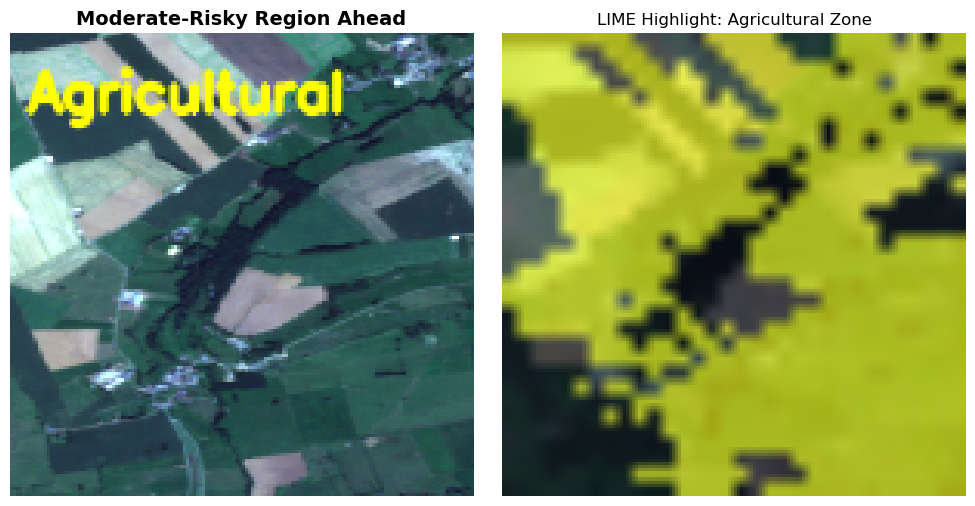

In [50]:
predictRoute(r"C:\Users\LASYA\OneDrive\Desktop\sar images\agri\ROIs1868_summer_s2_59_p4.png")


Attempting to load image from: C:\Users\LASYA\OneDrive\Desktop\sar images\barrenland\ROIs1970_fall_s2_2_p18.png
File exists: True


  0%|          | 0/1500 [00:00<?, ?it/s]

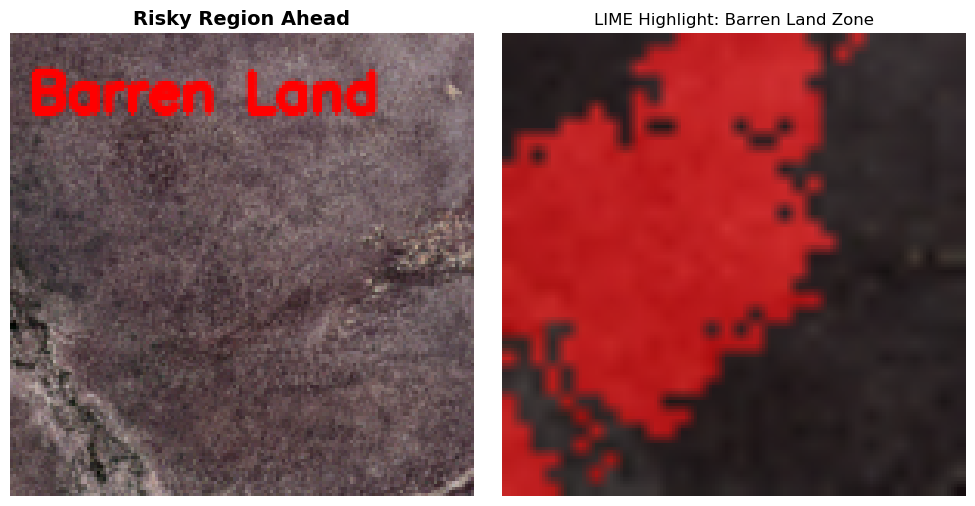

In [51]:
predictRoute(r"C:\Users\LASYA\OneDrive\Desktop\sar images\barrenland\ROIs1970_fall_s2_2_p18.png")

Attempting to load image from: C:\Users\LASYA\OneDrive\Desktop\sar images\urban\ROIs1970_fall_s2_8_p132.png
File exists: True


  0%|          | 0/1500 [00:00<?, ?it/s]

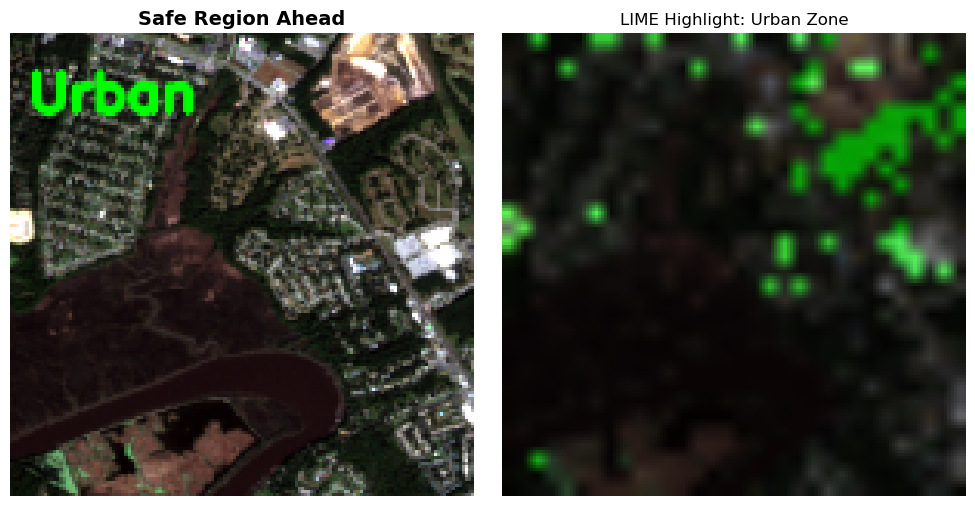

In [52]:
predictRoute(r"C:\Users\LASYA\OneDrive\Desktop\sar images\urban\ROIs1970_fall_s2_8_p132.png")

Attempting to load image from: C:\Users\LASYA\OneDrive\Desktop\sar images\grassland\ROIs1970_fall_s2_11_p5.png
File exists: True


  0%|          | 0/1500 [00:00<?, ?it/s]

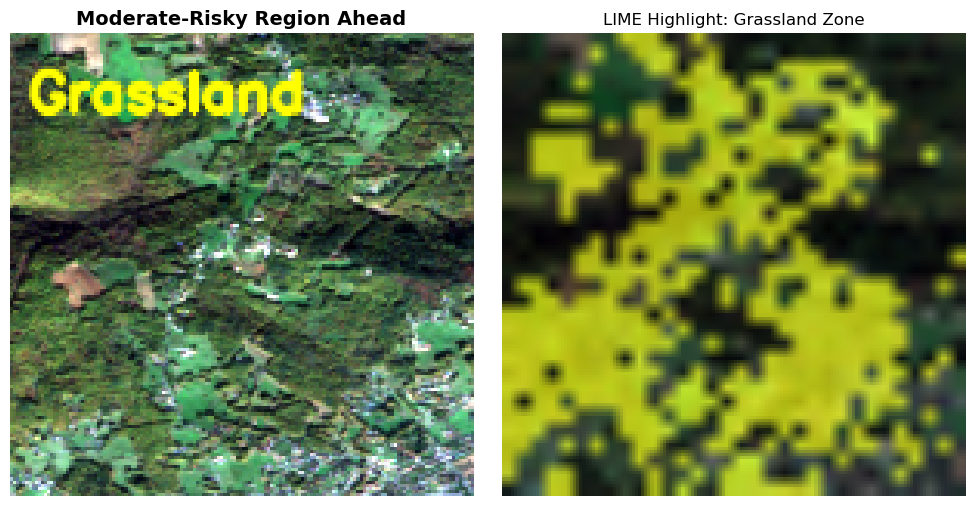

In [53]:
predictRoute(r"C:\Users\LASYA\OneDrive\Desktop\sar images\grassland\ROIs1970_fall_s2_11_p5.png")